# Projections and cross-gramian for FEM solutions on the dyadic-subdivided unit square

In [103]:
import numpy as np
import importlib
import dyadic_fem as df
import matplotlib.pyplot as plt
importlib.reload(df)
%matplotlib inline

### First we make our solution $u_h(x,y)$ for $h=2^{-\mathtt{fem-div}}$, and field $a(x,y)$
Again we solve the problem $-\nabla \cdot (a(x,y) \nabla u(x,y)) = f(x,y)$ using FEM. We then construct a basis of hat functions and sin functions on the grid of dyadic level $\mathtt{coarse\_div}$, both of which we also orthonormalise. Approximation in both the sin and hat functions should be the same as the bases span the same subspace of dyadic piece-wise linear functions

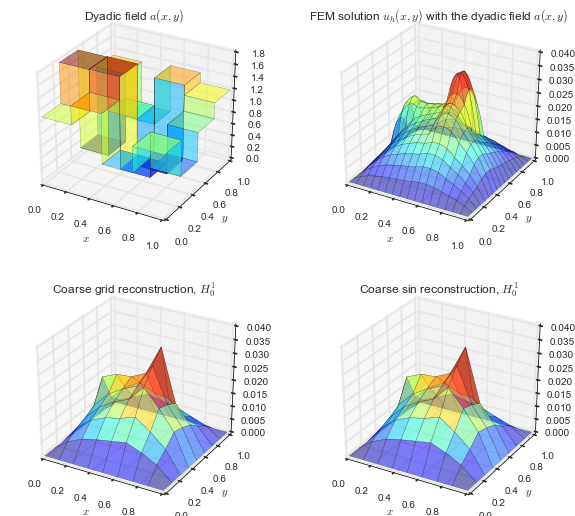

In [104]:
importlib.reload(df)

field_div = 2
fem_div = 8
coarse_div = 3

# First we generate our solution
a = df.DyadicRandomField(div=field_div, a_bar=1.0, c=0.99, seed=3)
fem = df.DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)
fem.solve()

coarse_grid = 2**coarse_div - 1
# Now make our bases
hat_b = df.make_hat_basis(coarse_div, space='H1')
sin_b = df.make_sine_basis(coarse_div, N=coarse_grid, M=coarse_grid, space='H1')

hat_b_ortho = hat_b.orthonormalise()
sin_b_ortho = sin_b.orthonormalise()

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(2, 2, 1, projection='3d')
a.field.plot(ax, title='Dyadic field $a(x,y)$')
ax = fig.add_subplot(2, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')
ax = fig.add_subplot(2, 2, 3, projection='3d')
hat_b.project(fem.u).plot(ax, title='Coarse grid reconstruction, $H^1_0$')
ax = fig.add_subplot(2, 2, 4, projection='3d')
sin_b.project(fem.u).plot(ax, title='Coarse sin reconstruction, $H^1_0$')

### We take average value around a point as our measurement, which has a representer of a simple indicator function around that point

n=49, m=225. Remember we require n <= m!


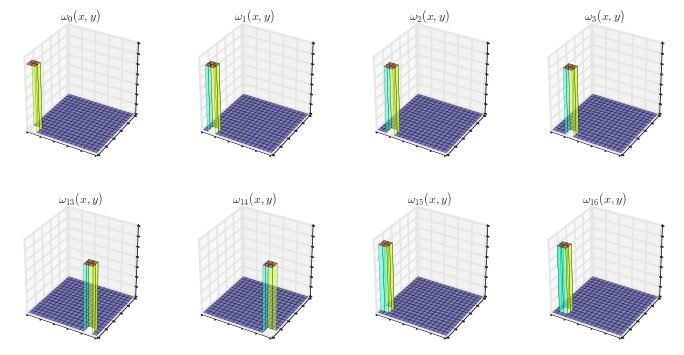

In [105]:
# And now make our measurements
meas_div = 4
M_m = []
for i in range(2**meas_div-1):
    for j in range(2**meas_div-1):
        h = 2**(-meas_div)
        meas = df.DyadicPWConstant(div=meas_div)
        meas.values[i:i+2,j:j+2] = 1.0 / (4*h*h)
        
        M_m.append(meas)
W = df.Basis(M_m, 'H1')

# Remember we need n = len(basis) to be less than m = len(measurements)
print("n={0}, m={1}. Remember we require n <= m!".format(len(sin_b.vecs), len(M_m)))

c = np.zeros(len(M_m))
for meas in M_m:
    fem.u.dot(meas, 'H1')
    
show_n = 4
fig = plt.figure(figsize=(12, 6))
for i in range(show_n):
    ax = fig.add_subplot(2, show_n, i+1, projection='3d')    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    W.vecs[i].plot(ax, title='$\omega_{{{0}}}(x,y)$'.format(i), show_axes_labels=False)

    ax = fig.add_subplot(2, show_n, i+1+show_n, projection='3d')    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    W.vecs[i+13].plot(ax, title='$\omega_{{{0}}}(x,y)$'.format(i+13), show_axes_labels=False)
    
W_ortho = W.orthonormalise()

In [111]:
# Ooops! I had the cross-grammian the wrong way around!
# e.g. G_hat = hat_b.cross_grammian(W)
# Should actually be this way around: G_hat = W.cross_grammian(hat_b)

print('Condition numbers')
for Phi in ('hat_b', 'sin_b', 'hat_b_ortho', 'sin_b_ortho'):
    for w in ('W', 'W_ortho'):
        G = eval(w).cross_grammian(eval(Phi))
        print(Phi + ' x\t' + w + '\t:\t {0}'.format(np.linalg.cond(G.T @ G)))


Condition numbers
hat_b x	W	:	 36.838431586653904
hat_b x	W_ortho	:	 11.283520691973877
sin_b x	W	:	 36.83843158665385
sin_b x	W_ortho	:	 11.283520691973877
hat_b_ortho x	W	:	 887.7055561585371
hat_b_ortho x	W_ortho	:	 271.8781501005534
sin_b_ortho x	W	:	 887.7055561585361
sin_b_ortho x	W_ortho	:	 271.87815010055317


Ok... condition numbers aren't tooo bad